### Performance Metrics

## Success Indicators

You have now been asked to discover what key performance indicators (KPIs) will determine the success of the new design? Use at least completion rate, time spent on each step and error rates. Add any KPIs you might find relevant.

- **Completion Rate:** The proportion of users who reach the final ‘confirm’ step.
- **Time Spent on Each Step:** The average duration users spend on each step.
- **Error Rates:** If there’s a step where users go back to a previous step, it may indicate confusion or an error. You should consider moving from a later step to an earlier one as an error.

## Redesign Outcome

Based on the chosen KPIs, how does the new design’s performance compare to the old one?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
# import reusable functions from utils directory
import sys
sys.path.append('../../utils')
import functions

In [4]:
df = pd.read_csv('../../data/clean/final_clean_client_df.csv')

In [5]:
df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')

# check if any dates couldn't be converted (i.e., they are NaT)
inconsistent_dates = df['date_time'].isna().sum()

# if inconsistent_dates > 0, then there are invalid or mismatched date formats
if inconsistent_dates > 0:
    print(f'There are {inconsistent_dates} inconsistent or invalid date formats in the column.')
else:
    print('All dates in the column have the same format.')

All dates in the column have the same format.


In [6]:
kpi_df = df.copy()
kpi_df = kpi_df.drop(columns=['Unnamed: 0'])


In [7]:
kpi_df

,client_id,visitor_id,visit_id,step,date_time,tenure_years,tenure_months,age,gender,accounts,balance,calls_last_6_months,logons_last_6_months,stepped_back,error_count,variation
0,169,201385055_71273495308,749567106_99161211863_557568,4,2017-04-12 20:23:09,21,262,47,Male,2,501570.72,4,4,False,4,Unknown
1,169,201385055_71273495308,749567106_99161211863_557568,3,2017-04-12 20:22:05,21,262,47,Male,2,501570.72,4,4,True,4,Unknown
2,169,201385055_71273495308,749567106_99161211863_557568,2,2017-04-12 20:20:31,21,262,47,Male,2,501570.72,4,4,True,4,Unknown
3,169,201385055_71273495308,749567106_99161211863_557568,1,2017-04-12 20:19:45,21,262,47,Male,2,501570.72,4,4,True,4,Unknown
4,169,201385055_71273495308,749567106_99161211863_557568,0,2017-04-12 20:19:36,21,262,47,Male,2,501570.72,4,4,True,4,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443767,9999839,948322592_28990736246,715530422_68620416793_515645,3,2017-03-29 12:12:28,13,160,28,Female,2,67425.35,3,3,True,4,Unknown
443768,9999839,948322592_28990736246,715530422_68620416793_515645,2,2017-03-29 12:11:50,13,160,28,Female,2,67425.35,3,3,True,4,Unknown
443769,9999839,948322592_28990736246,715530422_68620416793_515645,1,2017-03-29 12:11:35,13,160,28,Female,2,67425.35,3,3,True,4,Unknown
443770,9999839,948322592_28990736246,715530422_68620416793_515645,0,2017-03-29 12:11:32,13,160,28,Female,2,67425.35,3,3,True,4,Unknown


# **Completion Rate**

In [8]:
def find_completion_rate(df):    
    clients_finished = df[df['step'] == 4]
    total_unique_clients = df['client_id'].nunique()
    unique_clients_finished = clients_finished['client_id'].nunique()
    print(f'Clients who finished the process: {unique_clients_finished} out of {total_unique_clients}.')
    
    completion_count = clients_finished.groupby('client_id').size().reset_index(name='completion_count')
    print("Completion count (grouped by client_id):")
    print(completion_count.head())
    
    df = df.merge(completion_count[['client_id', 'completion_count']], on='client_id', how='left') # add completion_count column

    df['completion_count'] = df['completion_count'].fillna(0).astype(int) # replace NaN with 0 for clients who never finished
    
    print("Final DataFrame with completion count:")
    print(df[['client_id', 'completion_count']].head())
    
    return df

kpi_df = find_completion_rate(kpi_df)
kpi_df

Clients who finished the process: 47787 out of 70594.
Completion count (grouped by client_id):
   client_id  completion_count
0        169                 1
1        555                 1
2        647                 1
3        722                 1
4       1195                 1
Final DataFrame with completion count:
   client_id  completion_count
0        169                 1
1        169                 1
2        169                 1
3        169                 1
4        169                 1


,client_id,visitor_id,visit_id,step,date_time,tenure_years,tenure_months,age,gender,accounts,balance,calls_last_6_months,logons_last_6_months,stepped_back,error_count,variation,completion_count
0,169,201385055_71273495308,749567106_99161211863_557568,4,2017-04-12 20:23:09,21,262,47,Male,2,501570.72,4,4,False,4,Unknown,1
1,169,201385055_71273495308,749567106_99161211863_557568,3,2017-04-12 20:22:05,21,262,47,Male,2,501570.72,4,4,True,4,Unknown,1
2,169,201385055_71273495308,749567106_99161211863_557568,2,2017-04-12 20:20:31,21,262,47,Male,2,501570.72,4,4,True,4,Unknown,1
3,169,201385055_71273495308,749567106_99161211863_557568,1,2017-04-12 20:19:45,21,262,47,Male,2,501570.72,4,4,True,4,Unknown,1
4,169,201385055_71273495308,749567106_99161211863_557568,0,2017-04-12 20:19:36,21,262,47,Male,2,501570.72,4,4,True,4,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443767,9999839,948322592_28990736246,715530422_68620416793_515645,3,2017-03-29 12:12:28,13,160,28,Female,2,67425.35,3,3,True,4,Unknown,1
443768,9999839,948322592_28990736246,715530422_68620416793_515645,2,2017-03-29 12:11:50,13,160,28,Female,2,67425.35,3,3,True,4,Unknown,1
443769,9999839,948322592_28990736246,715530422_68620416793_515645,1,2017-03-29 12:11:35,13,160,28,Female,2,67425.35,3,3,True,4,Unknown,1
443770,9999839,948322592_28990736246,715530422_68620416793_515645,0,2017-03-29 12:11:32,13,160,28,Female,2,67425.35,3,3,True,4,Unknown,1


In [9]:
print('\nTimes that different clients completed the process:\n')
print(kpi_df['completion_count'].unique())


Times that different clients completed the process:

[ 1  0  3  2  6  5  4  7 10  8  9 12 19 11 17 14 16 15 13 20]


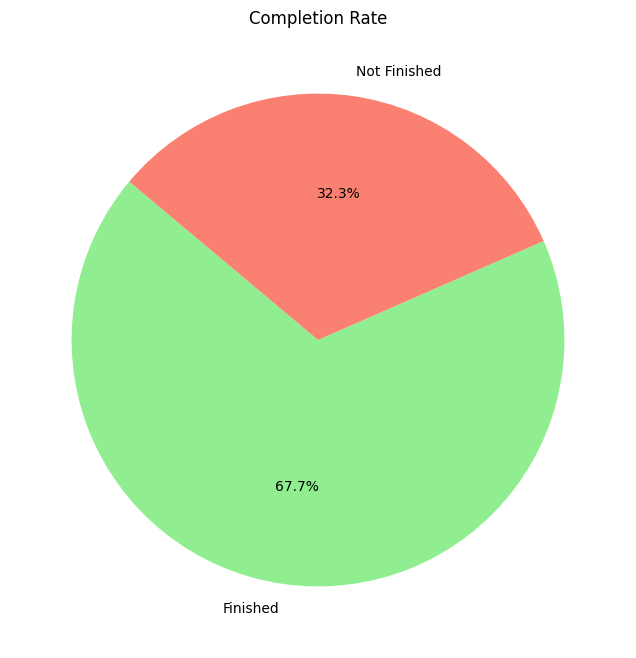

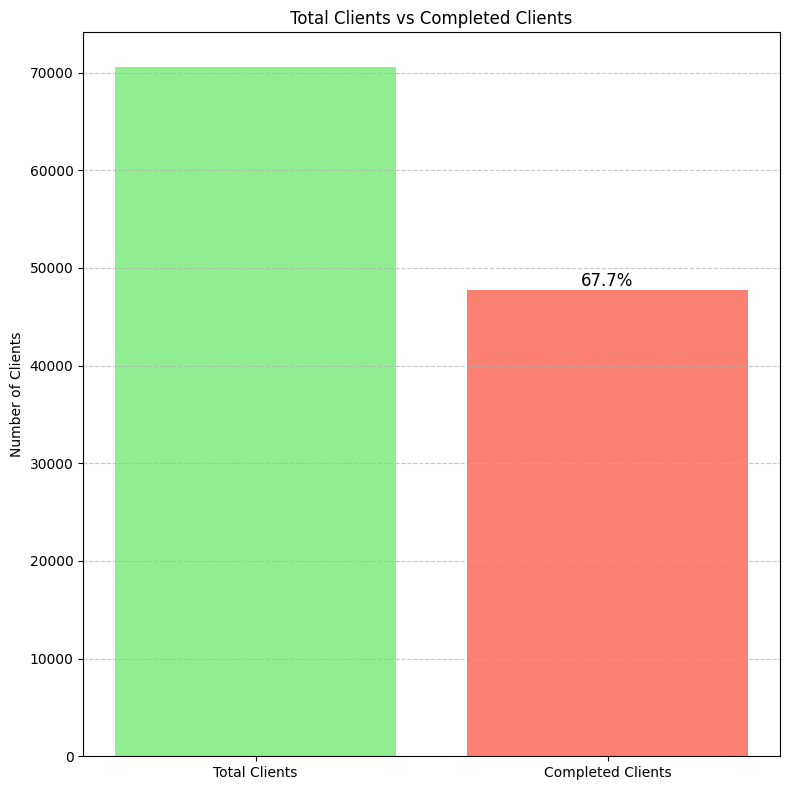

In [10]:
clients_finished = kpi_df[kpi_df['step'] == 4]['client_id'].nunique()
total_clients = kpi_df['client_id'].nunique()
clients_not_finished = total_clients - clients_finished

completion_rate = (clients_finished / total_clients) * 100

# pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    [clients_finished, clients_not_finished],
    labels=['Finished', 'Not Finished'],
    autopct='%1.1f%%',
    colors=['lightgreen', 'salmon'],
    startangle=140
)
plt.title('Completion Rate')
plt.show()

# bar chart
plt.figure(figsize=(8, 8))
bars = plt.bar(['Total Clients', 'Completed Clients'], [total_clients, clients_finished], color=['lightgreen', 'salmon'])

# add percentage annotation on top
plt.text(1, clients_finished + 1, f'{completion_rate:.1f}%', ha='center', va='bottom', fontsize=12, color='black')

plt.title('Total Clients vs Completed Clients')
plt.ylabel('Number of Clients')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [11]:
kpi_df

,client_id,visitor_id,visit_id,step,date_time,tenure_years,tenure_months,age,gender,accounts,balance,calls_last_6_months,logons_last_6_months,stepped_back,error_count,variation,completion_count
0,169,201385055_71273495308,749567106_99161211863_557568,4,2017-04-12 20:23:09,21,262,47,Male,2,501570.72,4,4,False,4,Unknown,1
1,169,201385055_71273495308,749567106_99161211863_557568,3,2017-04-12 20:22:05,21,262,47,Male,2,501570.72,4,4,True,4,Unknown,1
2,169,201385055_71273495308,749567106_99161211863_557568,2,2017-04-12 20:20:31,21,262,47,Male,2,501570.72,4,4,True,4,Unknown,1
3,169,201385055_71273495308,749567106_99161211863_557568,1,2017-04-12 20:19:45,21,262,47,Male,2,501570.72,4,4,True,4,Unknown,1
4,169,201385055_71273495308,749567106_99161211863_557568,0,2017-04-12 20:19:36,21,262,47,Male,2,501570.72,4,4,True,4,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443767,9999839,948322592_28990736246,715530422_68620416793_515645,3,2017-03-29 12:12:28,13,160,28,Female,2,67425.35,3,3,True,4,Unknown,1
443768,9999839,948322592_28990736246,715530422_68620416793_515645,2,2017-03-29 12:11:50,13,160,28,Female,2,67425.35,3,3,True,4,Unknown,1
443769,9999839,948322592_28990736246,715530422_68620416793_515645,1,2017-03-29 12:11:35,13,160,28,Female,2,67425.35,3,3,True,4,Unknown,1
443770,9999839,948322592_28990736246,715530422_68620416793_515645,0,2017-03-29 12:11:32,13,160,28,Female,2,67425.35,3,3,True,4,Unknown,1


# **Time spent on each step**

New approach: calculate the time difference between consecutive steps for each client during each visit (this time taking `'visit_id'`):

- Sort the Data: Sort by `'client_id'`, `'visit_id'`, and `'step'` to ensure that steps are ordered for each client within each session.
- Calculate Time Spent on Each Step: For each `'client_id'` and `'visit_id'`, calculate the difference between the timestamp of the current step and the next step for that client.
- Group by `'client_id'` and `'step'`: Calculate the average time spent on each step.

In [12]:
def calculate_average_time_per_step(df):
    df['date_time'] = pd.to_datetime(df['date_time'])
    
    df = df.sort_values(by=['client_id', 'visit_id', 'step'])
    
    df['next_step_time'] = df.groupby(['client_id', 'visit_id'])['date_time'].shift(-1) # calculate by shifting the 'date_time' column within each client and visit
    df['time_spent'] = df['next_step_time'] - df['date_time']
    
    step_4_rows = df[df['step'] == 4].copy()    
    step_4_rows['next_step_time'] = step_4_rows.groupby('visit_id')['date_time'].transform('max') # calculate 'next_step_time' as the max 'date_time' in each visit (end of the session)
    
    df.loc[df['step'] == 4, 'next_step_time'] = step_4_rows['next_step_time']
    df['time_spent'] = df['next_step_time'] - df['date_time'] # recalculate for step 4 after updating column
    df = df.dropna(subset=['time_spent']) # drop empty rows
    
    avg_time_per_step = df.groupby(['client_id', 'step'])['time_spent'].mean().reset_index(name='avg_time_spent') # group by and calculate
    
    # convert 'avg_time_spent' to total seconds and round up to the nearest integer using np.ceil()
    avg_time_per_step['avg_time_seconds'] = np.ceil(avg_time_per_step['avg_time_spent'].dt.total_seconds()).astype(int)
    avg_time_per_step['avg_time_minutes'] = avg_time_per_step['avg_time_seconds'] / 60

    avg_time_per_step['avg_time_minutes'] = avg_time_per_step['avg_time_minutes'].round(2) # round decimal in minutes
    
    return avg_time_per_step


time_per_step_df = calculate_average_time_per_step(kpi_df)

print(time_per_step_df.head())

   client_id  step  avg_time_spent  avg_time_seconds  avg_time_minutes
0        169     0 0 days 00:00:09                 9              0.15
1        169     1 0 days 00:00:46                46              0.77
2        169     2 0 days 00:01:34                94              1.57
3        169     3 0 days 00:01:04                64              1.07
4        169     4 0 days 00:00:00                 0              0.00


In [13]:
step_name_mapping = {0: 'Start', 1: 'Step 1', 2: 'Step 2', 3: 'Step 3', 4: 'Finish'}
time_per_step_df['step_name'] = time_per_step_df['step'].map(step_name_mapping)

time_per_step_df

,client_id,step,avg_time_spent,avg_time_seconds,avg_time_minutes,step_name
0,169,0,0 days 00:00:09,9,0.15,Start
1,169,1,0 days 00:00:46,46,0.77,Step 1
2,169,2,0 days 00:01:34,94,1.57,Step 2
3,169,3,0 days 00:01:04,64,1.07,Step 3
4,169,4,0 days 00:00:00,0,0.00,Finish
...,...,...,...,...,...,...
272937,9999839,0,0 days 00:00:01.500000,2,0.03,Start
272938,9999839,1,0 days 00:00:15,15,0.25,Step 1
272939,9999839,2,0 days 00:00:38,38,0.63,Step 2
272940,9999839,3,0 days 00:00:35,35,0.58,Step 3


/tmp/ipykernel_140149/1079986714.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='step_name', y='avg_time_minutes', data=time_per_step_df, palette='viridis')


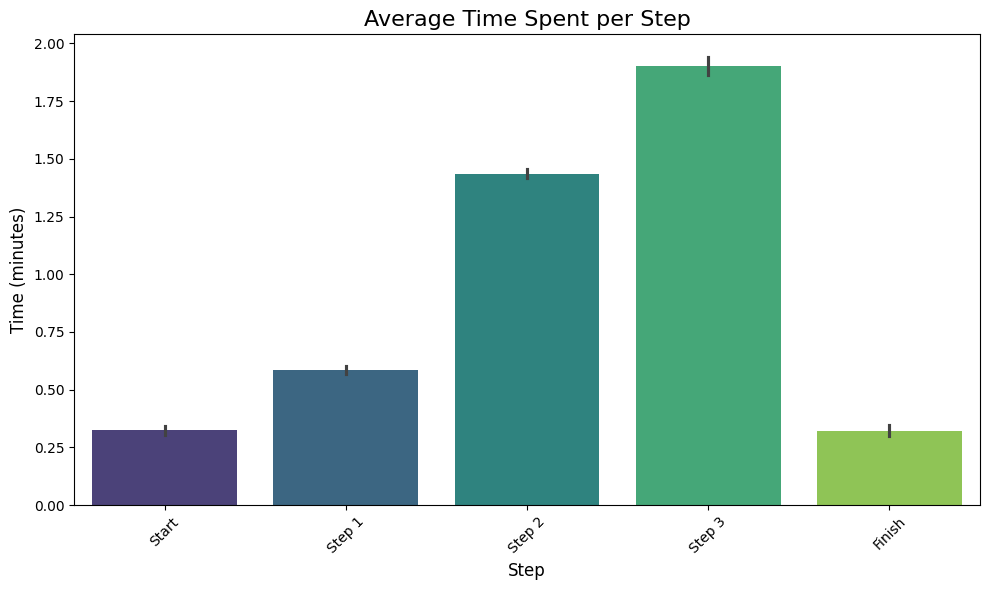

In [14]:
# Bar plot for average time spent per step (without hue)
plt.figure(figsize=(10, 6))
sns.barplot(x='step_name', y='avg_time_minutes', data=time_per_step_df, palette='viridis')

plt.title('Average Time Spent per Step', fontsize=16)
plt.xlabel('Step', fontsize=12)
plt.ylabel('Time (minutes)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

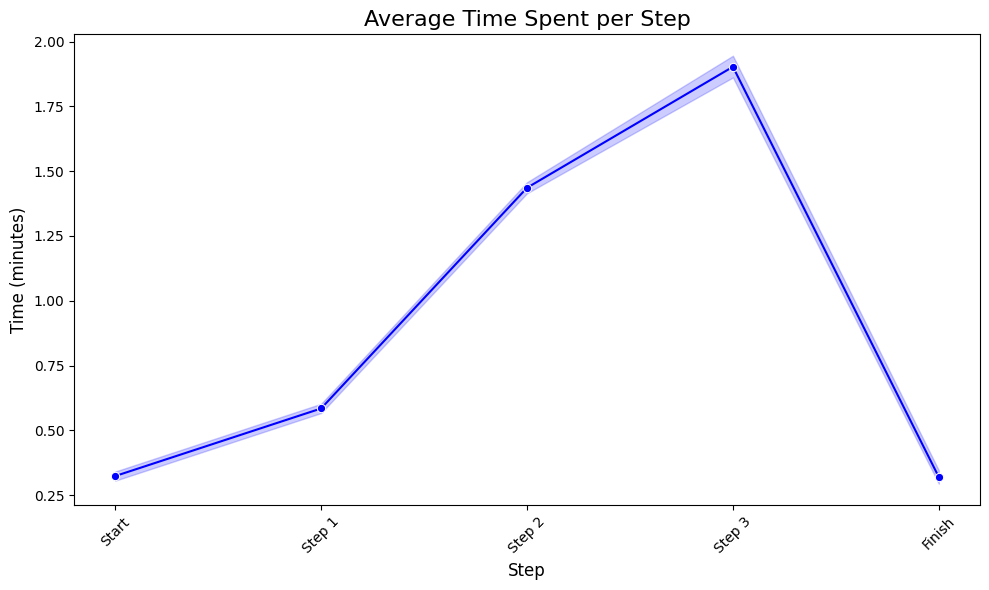

In [15]:
# Line plot for time spent across steps (can be useful to see trends)
plt.figure(figsize=(10, 6))
sns.lineplot(x='step_name', y='avg_time_minutes', data=time_per_step_df, marker='o', color='blue')
plt.title('Average Time Spent per Step', fontsize=16)
plt.xlabel('Step', fontsize=12)
plt.ylabel('Time (minutes)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

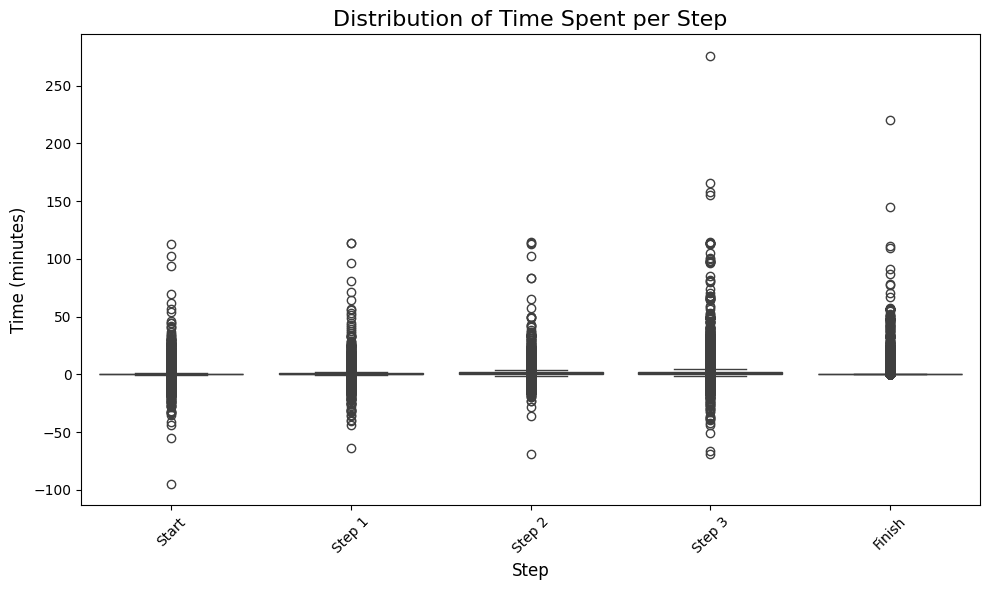

In [16]:
# Box plot to show distribution of time spent per step
plt.figure(figsize=(10, 6))
sns.boxplot(x='step_name', y='avg_time_minutes', data=time_per_step_df)
plt.title('Distribution of Time Spent per Step', fontsize=16)
plt.xlabel('Step', fontsize=12)
plt.ylabel('Time (minutes)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Error Rates**
_(Constanza's code)_

In [17]:
# df = pd.read_csv('../../data/clean/combined_cleaned_data.csv')

In [18]:
# sort df by client_id and date_time
# df = df.sort_values(by=['client_id', 'date_time'])

In [19]:
# # Detect backward steps (errors) for all clients
# df['backward_step'] = df.groupby('client_id')['step'].diff() < 0

# # Count the number of unique clients who experienced at least one error
# clients_with_errors = df[df['backward_step']]['client_id'].nunique()

# # Count the total number of errors for each client
# errors_per_client = df[df['backward_step']].groupby('client_id').size()

# # Total number of errors across all clients
# total_errors = df['backward_step'].sum()

# # Output results
# print(f'Number of clients with at least one error: {clients_with_errors}')
# print('Errors per client:')
# print(errors_per_client)
# print(f'Total number of errors across all clients: {total_errors}')

In [20]:
# # add column 'error_count'
# df['error_count'] = df['client_id'].map(errors_per_client).fillna(0).astype(int)

In [21]:
kpi_df

,client_id,visitor_id,visit_id,step,date_time,tenure_years,tenure_months,age,gender,accounts,balance,calls_last_6_months,logons_last_6_months,stepped_back,error_count,variation,completion_count
0,169,201385055_71273495308,749567106_99161211863_557568,4,2017-04-12 20:23:09,21,262,47,Male,2,501570.72,4,4,False,4,Unknown,1
1,169,201385055_71273495308,749567106_99161211863_557568,3,2017-04-12 20:22:05,21,262,47,Male,2,501570.72,4,4,True,4,Unknown,1
2,169,201385055_71273495308,749567106_99161211863_557568,2,2017-04-12 20:20:31,21,262,47,Male,2,501570.72,4,4,True,4,Unknown,1
3,169,201385055_71273495308,749567106_99161211863_557568,1,2017-04-12 20:19:45,21,262,47,Male,2,501570.72,4,4,True,4,Unknown,1
4,169,201385055_71273495308,749567106_99161211863_557568,0,2017-04-12 20:19:36,21,262,47,Male,2,501570.72,4,4,True,4,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443767,9999839,948322592_28990736246,715530422_68620416793_515645,3,2017-03-29 12:12:28,13,160,28,Female,2,67425.35,3,3,True,4,Unknown,1
443768,9999839,948322592_28990736246,715530422_68620416793_515645,2,2017-03-29 12:11:50,13,160,28,Female,2,67425.35,3,3,True,4,Unknown,1
443769,9999839,948322592_28990736246,715530422_68620416793_515645,1,2017-03-29 12:11:35,13,160,28,Female,2,67425.35,3,3,True,4,Unknown,1
443770,9999839,948322592_28990736246,715530422_68620416793_515645,0,2017-03-29 12:11:32,13,160,28,Female,2,67425.35,3,3,True,4,Unknown,1


## Error count (Taking `visit_id` into account)

In [22]:
kpi_df = kpi_df.drop(columns=['stepped_back', 'error_count'])


In [ ]:
def calculate_error_count(df):
    df = df.sort_values(by=['client_id', 'visit_id', 'date_time'])

    # Detect backward steps (errors) for all clients within each visit
    df['stepped_back'] = df.groupby(['client_id', 'visit_id'])['step'].diff() < 0

    # Calculate the total number of errors (steps that were "stepped back") for each client
    error_counts = df.groupby('client_id')['stepped_back'].sum()

    # Add column to the df
    df['error_count'] = df['client_id'].map(error_counts).fillna(0).astype(int)

    clients_with_errors = (df['error_count'] > 0).sum()

    total_errors = df['stepped_back'].sum()

    # percentage of clients with errors
    error_rate_clients = clients_with_errors / df['client_id'].nunique() * 100
    print(f'Error rate (clients with errors): {error_rate_clients:.2f}%')

    # percentage of total steps that are errors
    error_rate_steps = total_errors / len(df) * 100
    print(f'Error rate (steps with errors): {error_rate_steps:.2f}%')

    return df

kpi_df = calculate_error_count(kpi_df)

print(kpi_df.head())


Error rate (clients with errors): 288.83%
Error rate (steps with errors): 8.13%
   client_id             visitor_id                      visit_id  step  \
4        169  201385055_71273495308  749567106_99161211863_557568     0   
3        169  201385055_71273495308  749567106_99161211863_557568     1   
2        169  201385055_71273495308  749567106_99161211863_557568     2   
1        169  201385055_71273495308  749567106_99161211863_557568     3   
0        169  201385055_71273495308  749567106_99161211863_557568     4   

            date_time  tenure_years  tenure_months  age gender  accounts  \
4 2017-04-12 20:19:36            21            262   47   Male         2   
3 2017-04-12 20:19:45            21            262   47   Male         2   
2 2017-04-12 20:20:31            21            262   47   Male         2   
1 2017-04-12 20:22:05            21            262   47   Male         2   
0 2017-04-12 20:23:09            21            262   47   Male         2   

     balance

In [24]:
print(kpi_df['error_count'].unique())

[ 0  2  1  3  7  5  4 12  6  9  8 11 10 13 19 14 16 17 25 20 15 18 27]


# **Redesign Outcome**
Based on the chosen KPIs, how does the new design’s performance compare to the old one?

For the project requirements and instructions for today’s tasks in full, please refer to the project brief. However, in order to keep on track you may refer to the daily goals outlined below:

By the end of day, we recommend you have:

Reviewed KPI and Metrics material.
Discovered what key performance indicators (KPIs) will determine the success of the new design
Use at least completion rate, time spent on each step and error rates. Add any KPIs you might find relevant.
Evaluated how the new design’s performance compare to the old one, given the chosen KPIs (completion rate, time spent on each step and error rates).

Steps:
- [x] import `merged_final_demo_final_experiment_clients_df`
- [x] merge with `kpi_df`
- [x] add column of errors per client
- [x] clean data if needed

### Evaluate how the new design’s performance compare to the old one, given the chosen KPIs (completion rate, time spent on each step and error rates).



In [ ]:
# split in dfs, for Variation Control and Variation Test
df_test_kpi = merged_kpi_df[merged_kpi_df['variation'] == 'Test']
df_control_kpi = merged_kpi_df[merged_kpi_df['variation'] == 'Control']
df_unknown_kpi = merged_kpi_df[merged_kpi_df['variation'] == 'Unknown']

In [ ]:
# drop empty rows
df_test_kpi = df_test_kpi.dropna()
df_control_kpi = df_control_kpi.dropna()
df_unknown_kpi = df_unknown_kpi.dropna()

## Completion Rates

In [ ]:
print('\nCompletion rate for Control:')
functions.find_completion_rate(df_control_kpi)

In [ ]:
print('\nCompletion rate for Test:')
functions.find_completion_rate(df_test_kpi)

## Time spent on each step

In [ ]:
functions.calculate_time_per_step(df_test_kpi)

In [ ]:
functions.calculate_time_per_step(df_control_kpi)

## Error Rate

In [ ]:
functions.find_error_rate(df_test_kpi)

In [ ]:
functions.find_error_rate(df_control_kpi)

In [ ]:
functions.find_error_rate(df_unknown_kpi)

# Storing values

In [ ]:
# store the results for test df
test_unique_finished, test_total_clients, test_completion_rate = functions.find_completion_rate(df_test_kpi)
test_avg_time_per_step = functions.calculate_time_per_step(df_test_kpi)
test_clients_with_errors, test_errors_per_client, test_total_errors = functions.find_error_rate(df_test_kpi)

# store the results for control df
control_unique_finished, control_total_clients, control_completion_rate = functions.find_completion_rate(df_control_kpi)
control_avg_time_per_step = functions.calculate_time_per_step(df_control_kpi)
control_clients_with_errors, control_errors_per_client, control_total_errors = functions.find_error_rate(df_control_kpi)

# store the results for unknown df
unknown_finished, unknown_total_clients, unknown_completion_rate = functions.find_completion_rate(df_unknown_kpi)
unknown_avg_time_per_step = functions.calculate_time_per_step(df_unknown_kpi)
unknown_clients_with_errors, unknown_errors_per_client, unknown_total_errors = functions.find_error_rate(df_unknown_kpi)

## **Testing Plots**

In [ ]:
def plot_completion_rate(test_completion_rate, control_completion_rate):
    completion_rate_data = {
        'Version': ['Test', 'Control'],
        'Completion Rate': [test_completion_rate, control_completion_rate]
    }
    completion_rate_df = pd.DataFrame(completion_rate_data)
    
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x='Version', y='Completion Rate', data=completion_rate_df)
    
    ax.patches[0].set_facecolor('lightblue')
    ax.patches[1].set_facecolor('salmon') 
    
    plt.title('Completion Rate (Test vs Control)', fontsize=16)
    plt.ylabel('Completion Rate (%)')
    plt.show()

In [ ]:
def plot_avg_time_per_step(test_avg_time_per_step, control_avg_time_per_step):
    test_avg_time_seconds = test_avg_time_per_step.dt.total_seconds().round() # convert to seconds
    control_avg_time_seconds = control_avg_time_per_step.dt.total_seconds().round()

    time_data = {
        'Process Step': test_avg_time_per_step.index,
        'Test': test_avg_time_seconds.values,
        'Control': control_avg_time_seconds.values
    }
    time_df = pd.DataFrame(time_data)
    
    time_df.set_index('Process Step').plot(kind='bar', figsize=(10, 6), width=0.8, color=['lightblue', 'salmon'])
    plt.title('Average Time per Step (Test vs Control)', fontsize=16)
    plt.ylabel('Average Time (in seconds)')
    plt.xlabel('Step within the process')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_error_rate(test_clients_with_errors, control_clients_with_errors, test_total_errors, control_total_errors):
    clients_error_data = {
        'Version': ['Test', 'Control'],
        'Clients': [test_clients_with_errors, control_clients_with_errors]
    }
    clients_error_df = pd.DataFrame(clients_error_data)
    
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x='Version', y='Clients', data=clients_error_df)
    
    ax.patches[0].set_facecolor('cadetblue')
    ax.patches[1].set_facecolor('lightcoral')
    
    plt.title('Client Error Count (Test vs Control)', fontsize=16)
    plt.show()

    total_errors_data = {
        'Version': ['Test', 'Control'],
        'Total Errors': [test_total_errors, control_total_errors]
    }
    total_errors_df = pd.DataFrame(total_errors_data)
    
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x='Version', y='Total Errors', data=total_errors_df)
    
    ax.patches[0].set_facecolor('cadetblue')
    ax.patches[1].set_facecolor('lightcoral')
    
    plt.title('Total Error Count (Test vs Control)', fontsize=16)
    plt.show()

In [ ]:
plot_completion_rate(test_completion_rate, control_completion_rate)

In [ ]:
plot_avg_time_per_step(test_avg_time_per_step, control_avg_time_per_step)

In [ ]:
plot_error_rate(test_clients_with_errors, control_clients_with_errors, test_total_errors, control_total_errors)

## **More Plots!**

In [ ]:
# **Completion Rate Comparison - Pie Chart**

def plot_completion_rate_pie(test_completion_rate, control_completion_rate, unknown_completion_rate):
    completion_rate_data = {
        'Version': ['Test', 'Control', 'Unknown'],
        'Completion Rate': [test_completion_rate, control_completion_rate, unknown_completion_rate]
    }
    completion_rate_df = pd.DataFrame(completion_rate_data)
    
    # Pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(completion_rate_df['Completion Rate'], labels=completion_rate_df['Version'], autopct='%1.1f%%', startangle=90, colors=['lightblue', 'salmon', 'lightgray'])
    plt.title('Completion Rate (Test vs Control)')
    plt.show()

In [ ]:
# **Average Time per Step - Boxplot**

def plot_avg_time_per_step_boxplot(test_avg_time_per_step, control_avg_time_per_step):
    test_avg_time_seconds = test_avg_time_per_step.dt.total_seconds().round()  # Use .dt.total_seconds() for Series
    control_avg_time_seconds = control_avg_time_per_step.dt.total_seconds().round()  # Use .dt.total_seconds() for Series
    
    time_df = pd.DataFrame({
        'Process Step': ['Start', 'Step 1', 'Step 2', 'Step 3', 'Finish'],
        'Test': test_avg_time_seconds,
        'Control': control_avg_time_seconds
    })

    time_df = time_df.melt(id_vars='Process Step', value_vars=['Test', 'Control'], var_name='Version', value_name='Time (in seconds)')

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Process Step', y='Time (in seconds)', hue='Version', data=time_df)
    plt.title('Average Time per Step (Test vs Control)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
# **Error Rate - Heatmap of Errors per Client**

def plot_error_heatmap(test_errors_per_client, control_errors_per_client):
    error_data = {
        'Test': test_errors_per_client,
        'Control': control_errors_per_client
    }
    error_df = pd.DataFrame(error_data).T  # transpose to get rows as groups
    
    plt.figure(figsize=(8, 6))
    # Use 'f' for floating-point numbers, or use '.2f' for two decimal places
    sns.heatmap(error_df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True)
    plt.title('Error Count Heatmap (Test vs Control)')
    plt.show()

In [ ]:
plot_completion_rate_pie(test_completion_rate, control_completion_rate, unknown_completion_rate)

In [ ]:
plot_avg_time_per_step_boxplot(test_avg_time_per_step, control_avg_time_per_step)

In [ ]:
plot_error_heatmap(test_errors_per_client, control_errors_per_client)